In [1]:
import sys
sys.path.append('../')
sys.path.append('../support/')
from glob import glob
from os.path import join, isfile, basename
from multiprocessing import Pool
from scipy.ndimage.interpolation import rotate
from IPython.display import clear_output
from ct_reader import *
from tqdm import tqdm
from functools import partial
from matplotlib.pyplot import *
%pylab inline
import pickle
from paths import *
from scipy.misc import imresize

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
BATCH_SIZE = 10

In [3]:
def read_ct(path, ret_xy_spacing=False):
    patient = read_ct_scan(path)
    image = get_pixels_hu(patient)
    image[image == image[0,0,0]] = 0
    
    if ret_xy_spacing:
        try:
            return image, patient[0].PixelSpacing[0]
        except AttributeError:
            return image, scan.GetSpacing()[0]
    
    return image

    """
    Structure:
        1.  left lung     1
        2.  right lung    2
        4.  bronchi       0
        8.  trachea       0
        
        3.  left    overlapped by right     3
        
        5.  bronchi overlapped by left      1
        6.  bronchi overlapped by right     2
        7.  bronchi overlapped by right, overlapped by left      3
        
        9.  trachea overlapped by left      1
        10. trachea overlapped by right     2
        11. trachea overlapped by right, overlapped by left      3
            
        12. bronchi overlapped by trachea   0
        13. bronchi overlapped by trachea, overlapped by left    1 
        14. bronchi overlapped by trachea, overlapped by right   2
        15. bronchi overlapped by trachea, overlapped by right, overlapped by left  3
    """

In [4]:
def display(patient, mask):
    
    mask[(mask == 4) 
         | (mask == 12) 
         | (mask == 8)] = 0
    
    mask[(mask == 1) 
         | (mask == 5) 
         | (mask == 9)
         | (mask == 13)] = 1
    
    mask[(mask == 2) 
         | (mask == 6) 
         | (mask == 10)
         | (mask == 14)] = 2
    
    mask[(mask == 3) 
         | (mask == 7) 
         | (mask == 15)] = 3
    
    subplot(2, 2, 1)
    imshow(patient[patient.shape[0] // 2])
    axis('off')
    subplot(2, 2, 2)
    imshow(imresize(clip(patient[:, patient.shape[1] // 2], -1000, 400),
                    (patient.shape[0], patient.shape[0])))
    axis('off')
    subplot(2, 2, 3)
    imshow(mask[patient.shape[0] // 2])
    axis('off')
    subplot(2, 2, 4)
    imshow(imresize(mask[:, patient.shape[1] // 2], 
                    (patient.shape[0], patient.shape[0])))
    axis('off')
    show()

In [5]:
global_paths = sorted(list(set(pickle.load(open(join(PATH['WEIGHTS'], 'erroneus'), 'rb')))))
# erroneus = list()
# upsides = list()
iterations = int(ceil(len(global_paths) / BATCH_SIZE))

In [6]:
global_paths = [join(PATH['DATA'], path) for path in global_paths]

In [27]:
global_paths = glob(join(PATH['STAGE_MASKS'], "*[0-9a-f].npy"))
global_paths = sorted([join(PATH['STAGE_DATA'],basename(p).split('.npy')[0]) for p in global_paths])

In [16]:
global_paths = glob(join(PATH['STAGE_MASKS'],'FIXED', "[0-9a-f]*[0-9a-f].npy"))
global_paths = sorted([join(PATH['STAGE_DATA'],basename(p).split('.npy')[0]) for p in global_paths])

In [17]:
midev = 0#counter - 1

In [18]:
len(global_paths)

18

In [19]:
iterations

3

0 2 /home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/NEW_STAGE/DATA/1093f95635baf659ad5b3a893b14a0d9


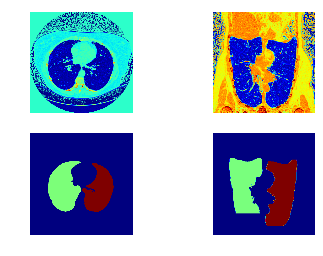

1 2 /home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/NEW_STAGE/DATA/148f7a4c3e46df7cd945c3ec96785ce8


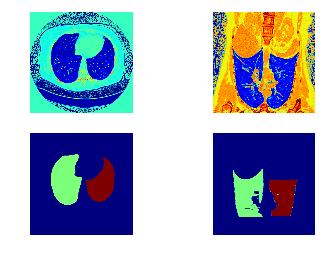

2 2 /home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/NEW_STAGE/DATA/1cd9c6588c6d8422056d8ef03c628e84


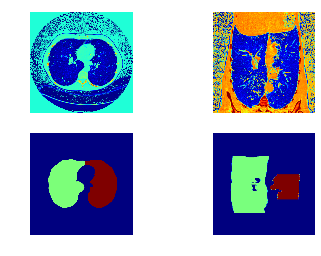

3 2 /home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/NEW_STAGE/DATA/219a499a3a84da4368627bb353d0762e


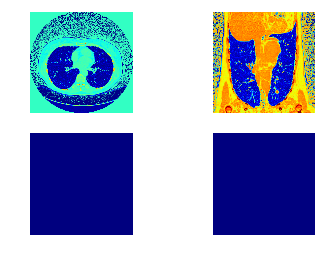

In [ ]:
### global_paths = glob(join(PATH['DATA'], '*'))
erroneus = list()
# upsides = list()
iterations = int(ceil(len(global_paths) / BATCH_SIZE))
for counter in range(midev, iterations):
    paths = global_paths[BATCH_SIZE * counter:
                         BATCH_SIZE * (counter + 1)]
    for i, path in enumerate(paths):
#         if (basename(path) in erroneus) or (basename(path) in upsides):
#             continue
        patient = read_ct(path)
        mask = load(join(PATH['STAGE_MASKS'],'FIXED', 
                         basename(path) + '.npy'))
        
        print(i, iterations - counter, path)
        display(patient, mask)
        
    while True:
        try:
            err = input()
            nomerus = list()
            if err != '':
                nomerus = list(map(int, err.split(' ')))
            ups = input()
            nomerus = [nomerus, []]
#             if ups != '':
#                 nomerus[1] = list(map(int, ups.split(' ')))
            break
        except:
            pass

    for i in nomerus[0]:
        erroneus.append(basename(paths[abs(i)]))
    pickle.dump(erroneus, 
                open(join(PATH['STAGE_MASKS'], 
                          'still_erroneus_ncrash'), 'wb'))
    
#     for i in nomerus[1]:
#         upsides.append(basename(paths[abs(i)]))
#     pickle.dump(upsides, 
#                 open(join(PATH['STAGE_MASKS'], 
#                           'upsides'), 'wb'))
    clear_output()
    

In [14]:
erroneus = pickle.load(open(join(PATH['STAGE_MASKS'], 
                      'still_erroneus_ncrash'), 'rb'))
upsides = pickle.load(open(join(PATH['STAGE_MASKS'], 
                      'upsides'), 'rb'))

In [15]:
len(erroneus)

18